# MIS 583 Assignment 3: Flower Classfication

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm 陳耀融, M094020055

## Flower Classification

Image classification is a core and fundamental task in computer vision.

In the assignment, you will implement a multi-class image classifier to recognize flowers.

You will design and train a deep convolutional network from scratch to predict the class label of a flower image. This will help you gain experience with network design and get more familiar with PyTorch.

**Please note that you’re not allowed to use a pre-trained model.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa) to join the competition.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.6.0`

In [2]:
# in our lab's server
# python=3.6.8, torch=1.6.0
!python3 --version
!pip3 freeze | grep torch

Python 3.6.8
torch==1.6.0
torchsummary==1.5.1
torchvision==0.7.0


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

This dataset contains 4323 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes: 
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Get Data

請先到共用雲端硬碟將檔案`flower_data.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1rTfeCpKXoQXI978QiTWC-AI1vwGvd5SU/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzip Data

解壓縮 `flower_data.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train`的圖片3112張，`val`的圖片778章，`test`的圖片433張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
!unzip -qq ./drive/My\ Drive/flower_data.zip

In [ ]:
# in our lab's server
!unzip -qq flower_data.zip

## Loading the dataset


### Custom dataset

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [3]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['file_path'])
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):

        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))

        return data, label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

Pytorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/docs/stable/torchvision/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

(**Slide.07 page.49**)

In [4]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = transforms.Compose([
    transforms.Resize(240),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [5]:
dataset_train = FlowerData('./data/train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('./data/val.csv', mode='val', transform=transforms_test)
dataset_test = FlowerData('./data/test.csv', mode='test', transform=transforms_test)

In [26]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", len(dataset_train), "images in dataset_train.")
print("There are", len(dataset_test), "images in dataset_test.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 3112 images in dataset_train.
There are 433 images in dataset_test.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=32, num_workers=16, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, num_workers=16, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, num_workers=16, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [8]:
# handmade resnext by myself
import torch.nn as nn 
import torch.nn.functional as F

# component conv1x1 and 3x3 of resnet
def conv1x1(in_chn, out_chn, stride=1):
    return nn.Conv2d(in_chn, out_chn, kernel_size=1,
                     stride=stride, bias=False)

def conv3x3(in_chn, out_chn, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_chn, out_chn, kernel_size=3,
                     stride=stride, padding=dilation,
                     groups=groups, bias=False, dilation=dilation)
                    # groups is keypoint for renext

# I also try resnet34 with BasicBlock
# class BasicBlock(nn.Module):

# Block of resnet50, resnet101, resnet152...
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_chn, out_chn, stride=1, downsample=None, groups=1, base_width=64):
        super().__init__()

        width = int(out_chn * (base_width / 64.)) * groups
        self.layers = nn.Sequential(
            conv1x1(in_chn, width),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),
            
            conv3x3(width, width, stride=stride, groups=groups),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),
            
            conv1x1(width, out_chn * self.expansion),
            nn.BatchNorm2d(out_chn * self.expansion),
        )
        self.downsample = downsample

    def forward(self, x):
        out = self.layers(x)
        
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

# ResNext Module
class ResNext50(nn.Module): 
    def __init__(self): 
        super().__init__()
        ########################################################################
        #     TODO: use nn.xxx method to generate a CNN model part             #
        ########################################################################
        # define core model
        # resnet50 32x4d setting
        block = BottleNeck
        layers = [3, 4, 6, 3]
        pre = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,
                      padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.in_chn = 64
        self.groups = 32 # default 1
        self.width_per_group = 4 # deafult 64
        self.base_width = self.width_per_group

        self.pre = pre
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stack blocks and layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512 * block.expansion, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 5),
        )

    # build several blocks together
    def _make_layer(self, block, out_chn, block_num, stride=1):
        downsample = None

        if stride != 1 or self.in_chn != out_chn * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_chn, out_chn * block.expansion, stride),
                nn.BatchNorm2d(out_chn * block.expansion),
            )

        layers = []
        layers.append(block(self.in_chn, out_chn, stride,
                            downsample, groups=self.groups,
                            base_width=self.base_width))
        self.in_chn = out_chn * block.expansion
        for _ in range(1, block_num):
            layers.append(block(self.in_chn, out_chn,
                                groups=self.groups,
                                base_width=self.base_width))

        return nn.Sequential(*layers)
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        ########################################################################
        #     TODO: forward your model and get output                          #
        ########################################################################
        x = self.pre(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        out = self.avg_pool(x)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

In [22]:
model = ResNext50()
model = model.cuda()
# print(model)

In [11]:
# using torchsummary check network and params
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [23]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
################################################################################
#                               End of your code                               #
################################################################################
# criterion = criterion.cuda()

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [13]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for i, data in enumerate(input_data, 0):
        images, labels = data[0].cuda(), data[1].cuda()
        
        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        pred = torch.argmax(outputs, dim=1)
        acc_count += (pred == labels).sum().item()
        total_count += images.shape[0]
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [14]:
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            images, labels = data[0].cuda(), data[1].cuda()

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            pred = torch.argmax(outputs, dim=1)
            acc_count += (pred == labels).sum().item()
            total_count += images.shape[0]
            loss_list.append(loss.item())
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [27]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 100
log_interval = 1 # print acc and loss in per log_interval time
# threshold to save checkpoints
max_loss = 0.7
max_acc = 0.7
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(51, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    # if get lower loss, save checkpoint
    if val_loss < max_loss:
        max_loss = val_loss
        torch.save(model.state_dict(), 'res_e{:03}_val_loss_{:.02}.pt'.format(epoch, val_loss))
    # if get higher acc, save checkpoint
    if val_acc > max_acc:
        max_acc = val_acc
        torch.save(model.state_dict(), 'res_acc_e{:03}_val_acc_{:.02}.pt'.format(epoch, val_acc))
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

==================== Epoch 51 ====================
Train Acc: 0.697301 Train Loss: 0.778310
  Val Acc: 0.703085   Val Loss: 0.734941
==================== Epoch 52 ====================
Train Acc: 0.693445 Train Loss: 0.786196
  Val Acc: 0.696658   Val Loss: 0.831493
==================== Epoch 53 ====================
Train Acc: 0.702121 Train Loss: 0.771395
  Val Acc: 0.724936   Val Loss: 0.757244
==================== Epoch 54 ====================
Train Acc: 0.669023 Train Loss: 0.857340
  Val Acc: 0.712082   Val Loss: 0.785891
==================== Epoch 55 ====================
Train Acc: 0.700514 Train Loss: 0.776444
  Val Acc: 0.664524   Val Loss: 0.842230
==================== Epoch 56 ====================
Train Acc: 0.710797 Train Loss: 0.752816
  Val Acc: 0.733933   Val Loss: 0.754134
==================== Epoch 57 ====================
Train Acc: 0.709190 Train Loss: 0.753632
  Val Acc: 0.745501   Val Loss: 0.717792
==================== Epoch 58 ====================
Train Acc: 0.72043

#### Visualize accuracy and loss

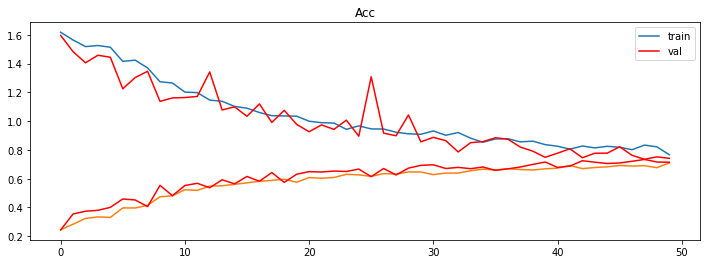

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
# plt.savefig('loss.png')÷
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.savefig('acc_loss.png')
# plt.show()

### Predict Result

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [24]:
# model = torch.load('res_e125_val_loss_0.43.pt')
ckpt = torch.load('res_acc_e191_val_acc_0.88.pt')
model.load_state_dict(ckpt) 

<All keys matched successfully>

In [16]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [25]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['Id', 'Category'])
    writer.writeheader()
    for result in output_csv:
        idx+=1
        writer.writerow({'Id':idx, 'Category':result})

# Keep trying and write report

持續調整模型、訓練方法、損失函數、優化器等，來訓練出更好的模型，並記錄使用不同參數得出的效果，以利後續 Report 的撰寫。

大家加油！